In [49]:

import requests
import csv

# Your Alpha Vantage API key
api_key = '5SRJ25KFE2K282K0'

# Function to fetch data for a given stock symbol
def fetch_stock_data(symbol):
    url = 'https://www.alphavantage.co/query'
    params = {
        'function': 'TIME_SERIES_DAILY',
        'symbol': symbol,
        'apikey': api_key
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    if "Time Series (Daily)" in data:
        return data['Time Series (Daily)']
    else:
        print(f"Error fetching data for {symbol}: {data.get('Note', 'No data found')}")
        return None

# List of stock symbols
stock_symbols = ['AAPL', 'TSLA', 'JPM', 'PFE', 'XOM']

# Open a new CSV file for writing
with open('stock_data.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    
    # Fetch data for each symbol and write to CSV
    for symbol in stock_symbols:
        stock_data = fetch_stock_data(symbol)
        if stock_data:
            for date, daily_data in stock_data.items():
                writer.writerow([
                    symbol,
                    date,
                    daily_data['1. open'],
                    daily_data['2. high'],
                    daily_data['3. low'],
                    daily_data['4. close'],
                    daily_data['5. volume']
                ])

print("Stock data written to CSV file successfully.")


Stock data written to CSV file successfully.


In [50]:
import requests
import csv

# Your News API key
api_key = 'a9dd58fced9045d18b1516c1fb48b6cc'

# The endpoint for everything (general search across news sources)
url = 'https://newsapi.org/v2/everything'

# Parameters for the request
params = {
    'q': 'AAPL OR TSLA OR JPM OR PFE OR XOM',  # Keywords or phrases to search for
    'sortBy': 'relevancy',  # Sort results by relevancy, popularity, or publishedAt
    'language': 'en',  # Language of the articles
    'apiKey': api_key
}

# Make the request
response = requests.get(url, params=params)
data = response.json()

# Check for successful response
if response.status_code == 200:
    # Extract articles
    articles = data['articles']
    
    # Define the CSV file headers
    csv_headers = ['Title', 'Source', 'URL', 'Published At', 'Description']
    
    # Open a new CSV file for writing
    with open('news_articles.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(csv_headers)
        
        # Write the article data
        for article in articles:
            writer.writerow([
                article['title'],
                article['source']['name'],
                article['url'],
                article['publishedAt'],
                article['description']
            ])
    
    print("New data written to CSV file successfully.")
else:
    print(f"Error: {data['message']}")


New data written to CSV file successfully.


In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read the CSV file into a DataFrame
df_stock = pd.read_csv('stock_data.csv')

# Display the first few rows to ensure data is loaded correctly
print(df_stock.head())

# Fill missing values with the forward fill method
df_stock.ffill(inplace=True)

# Convert 'Date' to datetime and set it as index
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)

# Define the window size for the moving average (20 days)
window_size = 20

# Adding previous days' prices as features
df_stock['Close_Lag1'] = df_stock['Close'].shift(1)
df_stock['Close_Lag2'] = df_stock['Close'].shift(2)

# Calculate daily return
df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100  # Multiply by 100 for percentage

# Adding lagged returns as features
df_stock['Return_Lag1'] = df_stock['Daily_Return'].shift(1)
df_stock['Return_Lag2'] = df_stock['Daily_Return'].shift(2)

# Calculate the moving average
df_stock['Moving_Avg'] = df_stock['Close'].rolling(window=window_size).mean()

# Calculate Rate of Change
df_stock['ROC'] = df_stock['Close'].pct_change(periods=12) * 100

# Extracting meaningful features for modeling stock prices
df_stock['SMA_20'] = df_stock['Close'].rolling(window=window_size).mean()
df_stock['EMA_20'] = df_stock['Close'].ewm(span=20, adjust=False).mean()

def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Measure Relative Strength Index (RSI)
df_stock['RSI'] = calculate_rsi(df_stock)

# Calculate 12-day and 26-day EMA
df_stock['EMA_12'] = df_stock['Close'].ewm(span=12, adjust=False).mean()
df_stock['EMA_26'] = df_stock['Close'].ewm(span=26, adjust=False).mean()

# Measure Moving Average Convergence Divergence (MACD)
df_stock['MACD'] = df_stock['EMA_12'] - df_stock['EMA_26']
df_stock['MACD_Signal'] = df_stock['MACD'].ewm(span=9, adjust=False).mean()

# Measure Volatility and Volume_Mean
df_stock['Volatility'] = df_stock['Close'].rolling(window=window_size).std()
df_stock['Volume_Mean'] = df_stock['Volume'].rolling(window=window_size).mean()

# Drop rows with NaN values introduced by shifting
df_stock.dropna(inplace=True)

# Reset index to make 'Date' a column again before normalization
df_stock.reset_index(inplace=True)

# Columns to normalize
columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']

# Ensure the columns to normalize exist
columns_to_normalize = [col for col in columns_to_normalize if col in df_stock.columns]

if not columns_to_normalize:
    print("No columns to normalize.")
else:
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the data
    df_stock[columns_to_normalize] = scaler.fit_transform(df_stock[columns_to_normalize])

    # Print the normalized DataFrame
    print(df_stock.head())

# Save the cleaned data to a new CSV file
df_stock.to_csv('cleaned_stock_article.csv', index=False)


  Symbol        Date    Open    High     Low   Close     Volume
0   AAPL  2024-08-09  212.04  216.78  211.98  216.24   41140161
1   AAPL  2024-08-08  213.11  214.20  208.83  213.31   47161149
2   AAPL  2024-08-07  206.90  213.64  206.39  209.82   63516417
3   AAPL  2024-08-06  205.30  209.99  201.07  207.23   69660488
4   AAPL  2024-08-05  199.09  213.50  196.00  209.27  119548589
        Date Symbol      Open      High       Low     Close    Volume  \
0 2024-07-15   AAPL  1.370153  1.329702  1.364126  1.335487  0.455831   
1 2024-07-12   AAPL  1.259387  1.263600  1.298594  1.279020  0.216672   
2 2024-07-11   AAPL  1.295577  1.260000  1.255352  1.235572  0.507716   
3 2024-07-10   AAPL  1.264955  1.269937  1.307064  1.314714  0.455742   
4 2024-07-09   AAPL  1.244882  1.216941  1.264299  1.251810  0.094988   

   Close_Lag1  Close_Lag2  Daily_Return  ...       ROC    SMA_20      EMA_20  \
0      234.82      228.88     -0.178860  ...  5.547550  220.1380  222.743456   
1      234.40    

In [52]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
# Download stopwords and punkt if not already available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the CSV file into a DataFrame (replace 'news_article.csv' with your actual file)
df_text = pd.read_csv('news_articles.csv')
# Assuming the columns with text data are named 'Title' and 'Description', replace with actual column names
text_columns = ['Title', 'Description']

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Check if the text is a string (to avoid errors with NaN or other types)
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize the text
        words = word_tokenize(text)
        # Remove stopwords and lemmatize the words
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        # Join the words back into a single string
        return ' '.join(words)
    else:
        return ''

# Apply the preprocessing function to each specified text column
for column in text_columns:
    df_text[f'Cleaned_{column}'] = df_text[column].apply(preprocess_text)
df_text.drop(columns=["URL", "Source"], inplace=True)
# Display the cleaned text columns
print(df_text[[f'Cleaned_{col}' for col in text_columns]].head())

# Save the cleaned data to a new CSV file
df_text.to_csv('cleaned_news_article.csv', index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akinahomwabella/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akinahomwabella/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akinahomwabella/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                       Cleaned_Title  \
0       tesla robotaxi wont ready scale 2030 analyst   
1          tesla building robotaxi there hidden cost   
2  exxonmobil xom reveals hammerhead project deve...   
3  9to5mac daily august 2 2024 – aapl q3 2024 ear...   
4  cathie wood say wouldnt sold nvidia stake know...   

                                 Cleaned_Description  
0  tesla tsla share trading higher friday despite...  
1  tesla tsla report latest quarterly report tues...  
2  exxonmobils xom development plan hammerhead in...  
3  today ’ episode 9to5mac daily discus apple rep...  
4  cathie wood investment fund ark invest sold le...  


In [53]:


# Import necessary libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import spacy

# Load the CSV files with cleaned data
df_cleaned_text = pd.read_csv('cleaned_news_article.csv')
df_cleaned_stock = pd.read_csv('cleaned_stock_article.csv')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def sentiment_analysis(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)['compound']
    else:
        return None

# Apply sentiment analysis to text data
df_cleaned_text['Title_Sentiment_Score'] = df_cleaned_text['Cleaned_Title'].apply(sentiment_analysis)
df_cleaned_text['Description_Sentiment_Score'] = df_cleaned_text['Cleaned_Description'].apply(sentiment_analysis)

# Convert 'Published At' column to datetime format
df_cleaned_text['Date'] = pd.to_datetime(df_cleaned_text['Published At'], errors='coerce')


# Calculate daily average sentiment scores
daily_sentiment = df_cleaned_text.groupby(df_cleaned_text['Date'].dt.date)['Title_Sentiment_Score'].mean()
daily_sentiment_df = daily_sentiment.reset_index()
daily_sentiment_df.columns = ['Date', 'Daily_Sentiment_Score']

# Convert 'Date' in daily_sentiment_df to datetime format for merging
daily_sentiment_df['Date'] = pd.to_datetime(daily_sentiment_df['Date'])

# Merge daily sentiment scores with stock data
df_cleaned_stock['Date'] = pd.to_datetime(df_cleaned_stock['Date'], errors='coerce')
df_cleaned_stock = pd.merge(df_cleaned_stock, daily_sentiment_df, on='Date', how='left')

# Aggregate sentiment scores by week
df_cleaned_text['Week'] = df_cleaned_text['Date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_sentiment = df_cleaned_text.groupby('Week')['Title_Sentiment_Score'].mean()
weekly_sentiment_df = weekly_sentiment.reset_index()
weekly_sentiment_df.columns = ['Week', 'Weekly_Sentiment_Score']

# Convert 'Week' in weekly_sentiment_df to datetime format for merging
weekly_sentiment_df['Week'] = pd.to_datetime(weekly_sentiment_df['Week'])

# Merge weekly sentiment scores with stock data
df_cleaned_stock['Week'] = df_cleaned_stock['Date'].dt.to_period('W').apply(lambda r: r.start_time)
df_cleaned_stock = pd.merge(df_cleaned_stock, weekly_sentiment_df, on='Week', how='left')

# Load the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define a function to get sentence embeddings using Sentence-BERT
def get_sentence_embedding(sentence):
    if isinstance(sentence, str):
        return model.encode(sentence)
    else:
        return np.zeros(model.get_sentence_embedding_dimension())


# Compute Word2Vec embeddings for each text
df_cleaned_text['Word2Vec_Embedding_Title'] = df_cleaned_text['Cleaned_Title'].apply(lambda x: get_sentence_embedding(x))
df_cleaned_text['Word2Vec_Embedding_Description'] = df_cleaned_text['Cleaned_Description'].apply(lambda x: get_sentence_embedding(x))

# Drop the original text columns
df_cleaned_text.drop(['Cleaned_Title', 'Cleaned_Description'], axis=1, inplace=True)
# Print the resulting DataFrame with sentiment scores and embeddings
print(df_cleaned_text[['Title_Sentiment_Score', 'Description_Sentiment_Score', 'Word2Vec_Embedding_Title','Word2Vec_Embedding_Description']].head())

# Save the DataFrame with sentiment scores and embeddings to a new CSV file
df_cleaned_text.to_csv('news_article_with_sentiment.csv', index=False)


/Users/akinahomwabella/Library/Python/3.9/lib/python/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/var/folders/pp/ckr57fqj6vb03g9vr4mbnvjw0000gn/T/ipykernel_37683/2201438188.py:43: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



   Title_Sentiment_Score  Description_Sentiment_Score  \
0                -0.2755                      -0.0258   
1                 0.0000                       0.0000   
2                 0.0000                      -0.3818   
3                 0.0000                      -0.1027   
4                 0.5719                       0.2263   

                            Word2Vec_Embedding_Title  \
0  [-0.011779225, -0.031012023, -0.09955558, -0.0...   
1  [-0.062481813, 0.034244537, -0.031933334, 0.00...   
2  [-0.023931492, -0.019036919, 0.07065436, -0.02...   
3  [-0.10454295, 0.01574082, 0.053382766, 0.05218...   
4  [0.026826339, -0.021405887, -0.026352998, -0.0...   

                      Word2Vec_Embedding_Description  
0  [-0.050417252, -0.05723135, -0.00022364523, 0....  
1  [-0.022078425, -0.018386573, -0.018221067, 0.0...  
2  [-0.018905027, 0.016774863, 0.024963025, -0.01...  
3  [-0.09519099, 0.03768049, 0.081707604, -0.0286...  
4  [0.096326, -0.015384293, -0.072952285, 0.0

In [54]:
import pandas as pd

# Read the CSV files into DataFrames
df1 = pd.read_csv('cleaned_stock_article.csv')
df2 = pd.read_csv('news_article_with_sentiment.csv')

df2.drop(columns=["Title", "Description","Published At"], inplace=True)
# Convert 'Date' columns to datetime format for consistency
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')

# Ensure both 'Date' columns are naive datetime (without timezone)
df2['Date'] = df2['Date'].dt.tz_localize(None)
df2['Year'] = df2['Date'].dt.year
df2['Month'] = df2['Date'].dt.month
df2['Day'] = df2['Date'].dt.day
concat_df = pd.concat([df1, df2], axis=1)

# Step 2: Verify the merge
print("Merged DataFrame head:")
print(concat_df.head())
print("Merged DataFrame info:")
print(concat_df.info())
# Save the merged DataFrame to a new CSV file
concat_df.to_csv('merged.csv', index=False)

Merged DataFrame head:
        Date Symbol      Open      High       Low     Close    Volume  \
0 2024-07-15   AAPL  1.370153  1.329702  1.364126  1.335487  0.455831   
1 2024-07-12   AAPL  1.259387  1.263600  1.298594  1.279020  0.216672   
2 2024-07-11   AAPL  1.295577  1.260000  1.255352  1.235572  0.507716   
3 2024-07-10   AAPL  1.264955  1.269937  1.307064  1.314714  0.455742   
4 2024-07-09   AAPL  1.244882  1.216941  1.264299  1.251810  0.094988   

   Close_Lag1  Close_Lag2  Daily_Return  ...  Volume_Mean  \
0      234.82      228.88     -0.178860  ...  57920895.35   
1      234.40      234.82     -1.646758  ...  58516213.65   
2      230.54      234.40     -1.288280  ...  59393687.05   
3      227.57      230.54      2.377291  ...  59349250.55   
4      232.98      227.57     -1.845652  ...  58274717.25   

   Title_Sentiment_Score  Description_Sentiment_Score                Date  \
0                -0.2755                      -0.0258 2024-07-12 15:19:12   
1                

In [55]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('merged.csv')

# Convert 'Date' to datetime and extract year, month, and day
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns=['Date'], inplace=True)  # Drop the original Date column
# One-hot encode the 'Symbol' column
df = pd.get_dummies(df, columns=['Symbol'])
# Shift the 'Close' prices to create 'Future_Close'
df['Future_Close'] = df['Close'].shift(-1)
# Drop the last row which will have NaN value in 'Future_Close'
df.dropna(inplace=True)

# Define target and features
y = df['Future_Close']
X = df.drop(['Future_Close'], axis=1)
# Ensure all feature columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')
X.dropna(inplace=True, axis=1)  # Drop columns with NaN values after conversion

# Initialize the models
linear_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor()

# Perform RFE with Linear Regression
rfe_linear = RFE(estimator=linear_model, n_features_to_select=10)
X_rfe_linear = rfe_linear.fit_transform(X, y)
ranking_linear = rfe_linear.ranking_

# Print feature rankings and selected features for Linear Regression
print("Feature Rankings (Linear Regression):", ranking_linear)
print("Selected Features (Linear Regression):", X.columns[rfe_linear.support_])

# Perform RFE with Decision Tree
rfe_tree = RFE(estimator=decision_tree_model, n_features_to_select=10)
X_rfe_tree = rfe_tree.fit_transform(X, y)
ranking_tree = rfe_tree.ranking_

# Print feature rankings and selected features for Decision Tree
print("Feature Rankings (Decision Tree):", ranking_tree)
print("Selected Features (Decision Tree):", X.columns[rfe_tree.support_])

# Split the data into training and test sets for both models
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_rfe_linear, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_rfe_tree, y, test_size=0.2, random_state=42)

# Train the models on the selected features
linear_model.fit(X_train_linear, y_train_linear)
decision_tree_model.fit(X_train_tree, y_train_tree)

# Evaluate the models
linear_score = linear_model.score(X_test_linear, y_test_linear)
decision_tree_score = decision_tree_model.score(X_test_tree, y_test_tree)

print("Linear Regression Model Accuracy:", linear_score)
print("Decision Tree Model Accuracy:", decision_tree_score)
# Making predictions
y_pred_linear = linear_model.predict(X_test_linear)
y_pred_tree = decision_tree_model.predict(X_test_tree)

# Print or save predictions
print("Linear Regression Predictions:", y_pred_linear)
print("Decision Tree Predictions:", y_pred_tree)

# Optionally, compare the predictions with actual values
comparison_linear = pd.DataFrame({'Actual': y_test_linear, 'Predicted': y_pred_linear})
comparison_tree = pd.DataFrame({'Actual': y_test_tree, 'Predicted': y_pred_tree})

print("Linear Regression Prediction vs Actual:\n", comparison_linear.head())
print("Decision Tree Prediction vs Actual:\n", comparison_tree.head())

Feature Rankings (Linear Regression): [ 1  1  1  1  4 11 10  5  6 13 14  8 16  2 15  1  1  1  3 12 18  1  9 20
  7 17  1 21 19  1 22]
Selected Features (Linear Regression): Index(['Open', 'High', 'Low', 'Close', 'EMA_12', 'EMA_26', 'MACD',
       'Title_Sentiment_Score', 'Symbol_AAPL', 'Symbol_TSLA'],
      dtype='object')
Feature Rankings (Decision Tree): [ 1  1  4  1  6  1  1 10  5  8  3 14 12  1  1 15  7  2  1  1 13  9 11 17
 16  1 18 21 19 20 22]
Selected Features (Decision Tree): Index(['Open', 'High', 'Close', 'Close_Lag1', 'Close_Lag2', 'EMA_20', 'RSI',
       'MACD_Signal', 'Volatility', 'Day'],
      dtype='object')
Linear Regression Model Accuracy: 0.985202634551514
Decision Tree Model Accuracy: 0.9483892610227932
Linear Regression Predictions: [0.65202441 0.85612598 0.32927051 0.38981738 1.27678027 0.71696582
 0.63298144 0.36174121 1.09855762 0.55070605 1.34188853 0.69255176
 1.58944713 0.45134082 0.98137012 1.21550098 0.99699512 0.70915332
 0.43815723]
Decision Tree Predict

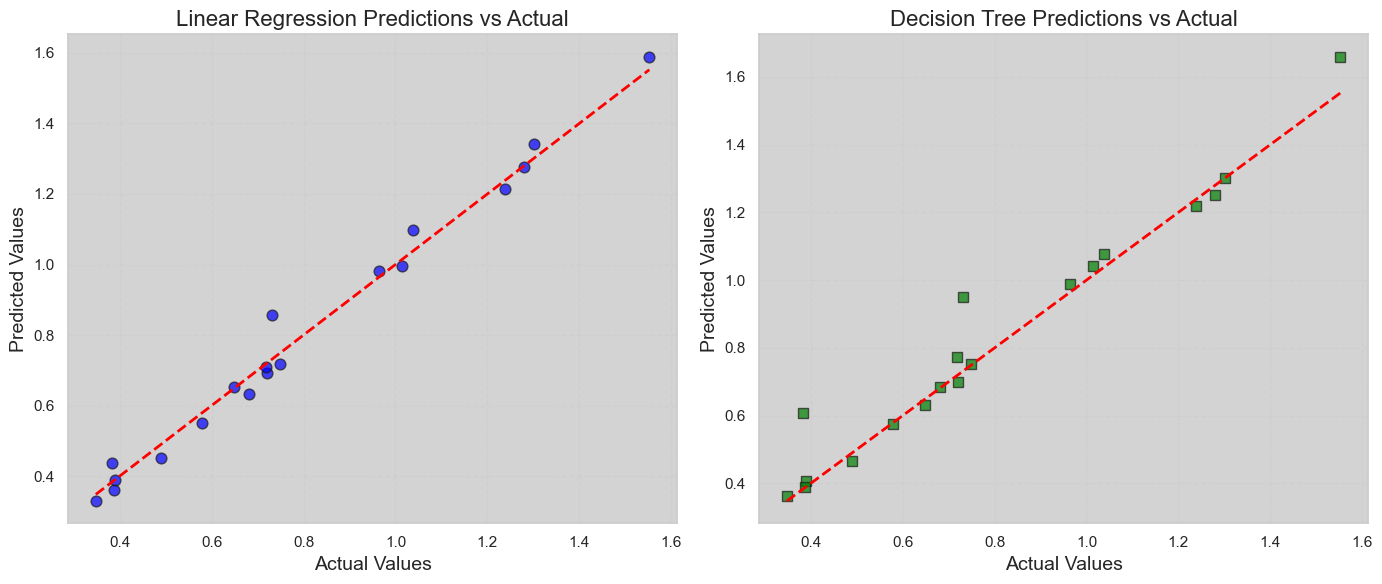

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test_linear, y_pred_linear, color='blue', alpha=0.7, edgecolor='k', s=60, marker='o')
plt.plot([min(y_test_linear), max(y_test_linear)], [min(y_test_linear), max(y_test_linear)], color='red', linestyle='--', linewidth=2)
plt.title('Linear Regression Predictions vs Actual', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('lightgrey')  # Set background color for better contrast

# Decision Tree
plt.subplot(1, 2, 2)
plt.scatter(y_test_tree, y_pred_tree, color='green', alpha=0.7, edgecolor='k', s=60, marker='s')
plt.plot([min(y_test_tree), max(y_test_tree)], [min(y_test_tree), max(y_test_tree)], color='red', linestyle='--', linewidth=2)
plt.title('Decision Tree Predictions vs Actual', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('lightgrey')  # Set background color for better contrast

plt.tight_layout()
plt.show()


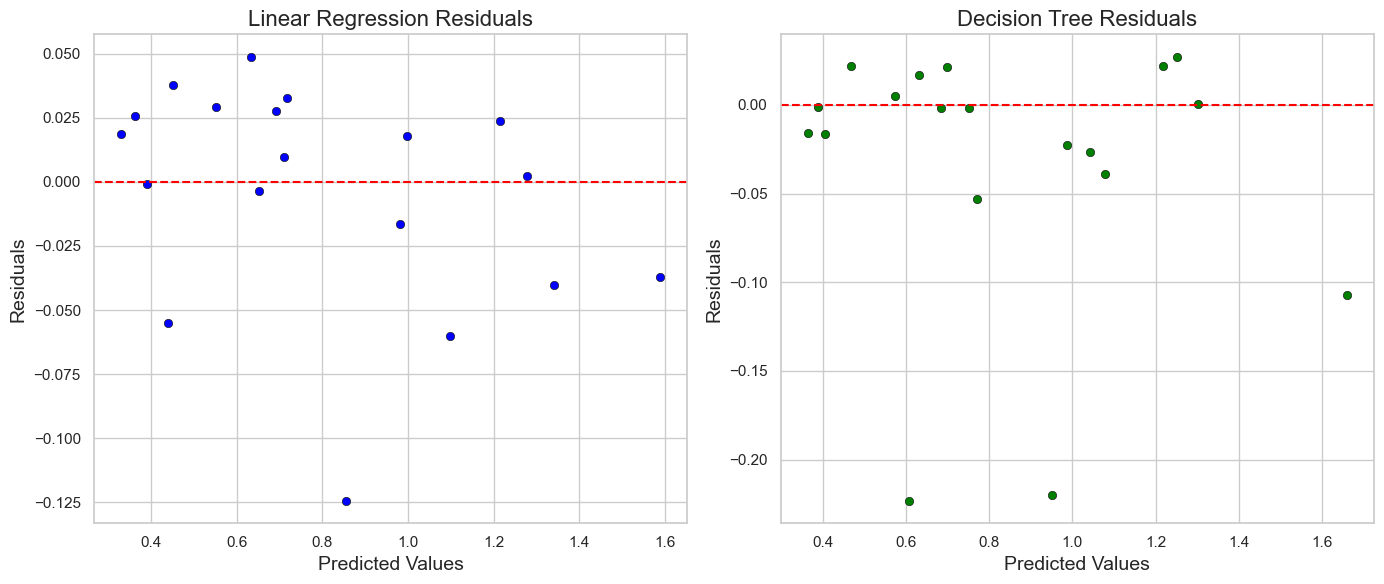

In [57]:
import seaborn as sns

# Calculate residuals
residuals_linear = y_test_linear - y_pred_linear
residuals_tree = y_test_tree - y_pred_tree

plt.figure(figsize=(14, 6))

# Linear Regression Residuals
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_linear, y=residuals_linear, color='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Linear Regression Residuals', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

# Decision Tree Residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_tree, y=residuals_tree, color='green', edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Decision Tree Residuals', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.tight_layout()
plt.show()


In [58]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import joblib

# Load your dataset
df = pd.read_csv('merged.csv')

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns=['Date'], inplace=True)
df = pd.get_dummies(df, columns=['Symbol'])
df['Future_Close'] = df['Close'].shift(-1)
df.dropna(inplace=True)

# Define target and features
y = df['Future_Close']
X = df.drop(['Future_Close'], axis=1)

# Label encoding for categorical columns
label_encoders = {}
for column in ['Date.1', 'Week']:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

# Define embedding dimension
embedding_dim = 32  

# Flatten embeddings
def flatten_embeddings(df, column_name, num_features):
    # Check the type of embeddings and convert accordingly
    def parse_embedding(embedding):
        if isinstance(embedding, str):
            try:
                return np.fromstring(embedding.strip('[]'), sep=' ')
            except:
                return np.array([])
        else:
            return np.array(embedding)
    
    embeddings = df[column_name].apply(parse_embedding)
    for i in range(num_features):
        df[f'{column_name}_feature_{i}'] = embeddings.apply(lambda x: x[i] if len(x) > i else np.nan)

# Apply the flatten_embeddings function
flatten_embeddings(df, 'Word2Vec_Embedding_Description', num_features=embedding_dim)

# Remove original embedding columns
df = df.drop(columns=['Word2Vec_Embedding_Title', 'Word2Vec_Embedding_Description'])

# Ensure all columns are numeric
X = df.drop(['Future_Close'], axis=1)
X = X.apply(pd.to_numeric, errors='coerce')

# Check data types
print(X.dtypes)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
print(y_pred)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Feature importance
importances = xgb_model.feature_importances_
feature_names = X.columns
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importances_df.sort_values(by='Importance', ascending=False))

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_}")

# Save the model
joblib.dump(xgb_model, 'xgb_model.pkl')

# Load the model (example of how to load it later)
loaded_model = joblib.load('xgb_model.pkl')

# Make predictions with the loaded model
y_pred_loaded = loaded_model.predict(X_test)
print(y_pred_loaded )
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
print(f"Mean Squared Error with loaded model: {mse_loaded}")


Open                                         float64
High                                         float64
Low                                          float64
Close                                        float64
Volume                                       float64
                                              ...   
Word2Vec_Embedding_Description_feature_27    float64
Word2Vec_Embedding_Description_feature_28    float64
Word2Vec_Embedding_Description_feature_29    float64
Word2Vec_Embedding_Description_feature_30    float64
Word2Vec_Embedding_Description_feature_31    float64
Length: 65, dtype: object
[0.64009446 0.9371375  0.3404251  0.39827237 1.2453853  0.75021744
 0.6842807  0.39615405 1.0788552  0.5723009  1.2841487  0.6883042
 1.4938549  0.45669538 0.97115517 1.2522962  0.9889219  0.69888705
 0.5203821 ]
Mean Squared Error: 0.0037526254505146767
                                      Feature  Importance
1                                        High    0.796531
18                  

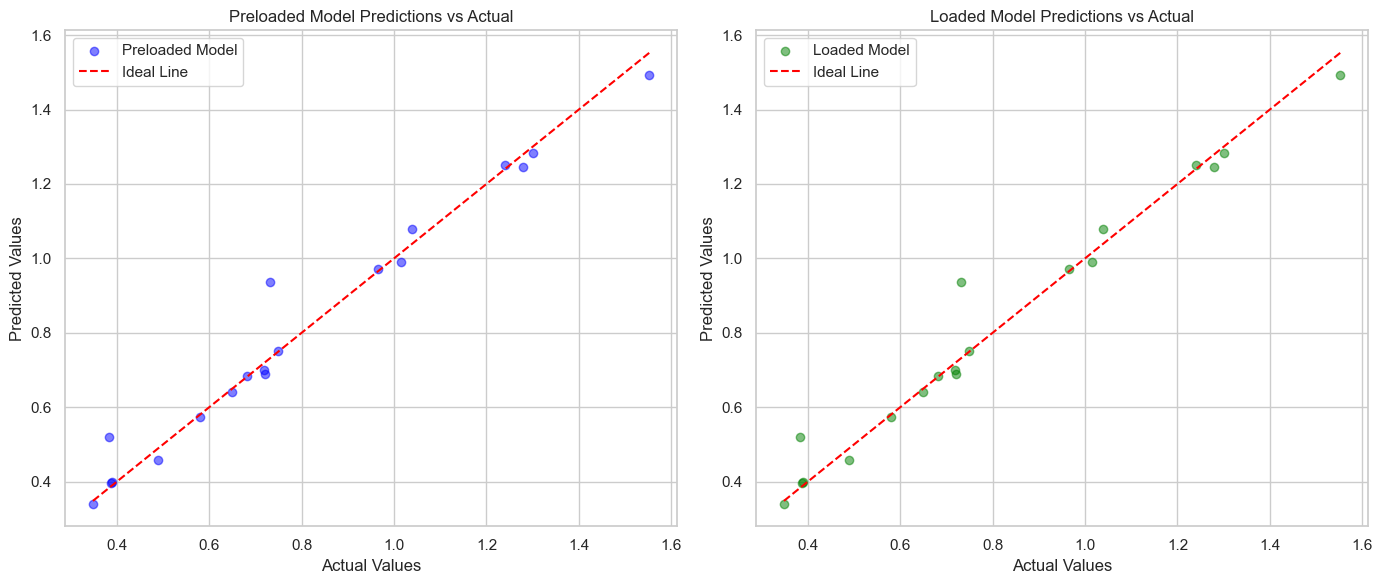

In [59]:
import matplotlib.pyplot as plt

# Make predictions with the preloaded model
y_pred_preloaded = xgb_model.predict(X_test)

# Compare predictions of preloaded and loaded models
plt.figure(figsize=(14, 6))

# Preloaded model
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_preloaded, color='blue', alpha=0.5, label='Preloaded Model')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.title('Preloaded Model Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Loaded model
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_loaded, color='green', alpha=0.5, label='Loaded Model')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.title('Loaded Model Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.tight_layout()
plt.show()


In [60]:
%pip install keras
%pip install tensorflow

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Load and preprocess your dataset
df = pd.read_csv('merged.csv')

# Convert Date to datetime and create new features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns=['Date'], inplace=True)
df['Future_Close'] = df['Close'].shift(-1)
df = pd.get_dummies(df, columns=['Symbol'])
df.dropna(inplace=True)

# Label encoding for categorical columns
label_encoders = {}
for column in ['Date.1', 'Week']:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

# Define embedding dimension
embedding_dim = 32  

# Flatten embeddings
def flatten_embeddings(df, column_name, num_features):
    def parse_embedding(embedding):
        if isinstance(embedding, str):
            try:
                return np.fromstring(embedding.strip('[]'), sep=' ')
            except:
                return np.array([])
        else:
            return np.array(embedding)
    
    embeddings = df[column_name].apply(parse_embedding)
    for i in range(num_features):
        df[f'{column_name}_feature_{i}'] = embeddings.apply(lambda x: x[i] if len(x) > i else np.nan)

# Apply the flatten_embeddings function
flatten_embeddings(df, 'Word2Vec_Embedding_Description', num_features=embedding_dim)

# Remove original embedding columns
df = df.drop(columns=['Word2Vec_Embedding_Title', 'Word2Vec_Embedding_Description'])

# Ensure all columns are numeric
X = df.drop(['Future_Close'], axis=1)
X = X.apply(pd.to_numeric, errors='coerce')

# Create lag features for LSTM input
def create_lagged_features(df, lag=1):
    for i in range(1, lag+1):
        df[f'Close_Lag{i}'] = df['Close'].shift(i)
    return df

# Add lag features
df = create_lagged_features(df, lag=5)
df.dropna(inplace=True)

# Define target and features
y = df['Future_Close']
X = df.drop(['Future_Close'], axis=1)

# Convert to NumPy arrays and ensure consistent dtype
X = X.values.astype(np.float32)
y = y.values.astype(np.float32)

# Reshape data for LSTM
timesteps = 5  # Number of timesteps for LSTM
num_features = X.shape[1]

def create_lstm_dataset(X, y, timesteps):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - timesteps):
        X_lstm.append(X[i:i+timesteps])
        y_lstm.append(y[i+timesteps])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm, y_lstm = create_lstm_dataset(X, y, timesteps)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and train the model
input_shape = (timesteps, num_features)
lstm_model = build_lstm_model(input_shape)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Make predictions
y_pred = lstm_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"LSTM Mean Squared Error: {mse}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Epoch 1/10


/Users/akinahomwabella/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.2601 - val_loss: 0.2710
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1414 - val_loss: 0.1809
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1366 - val_loss: 0.1792
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1574 - val_loss: 0.1773
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1486 - val_loss: 0.1825
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1250 - val_loss: 0.2071
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1174 - val_loss: 0.2403
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1318 - val_loss: 0.2551
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1237 - val_loss: 0.2495
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1485 - val_loss: 0.2282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
LSTM Mean Squared Error: 0.12989461421966553


In [61]:
%pip install keras
%pip install tensorflow

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Load and preprocess your dataset
df = pd.read_csv('merged.csv')

# Convert Date to datetime and create new features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns=['Date'], inplace=True)
df['Future_Close'] = df['Close'].shift(-1)
df = pd.get_dummies(df, columns=['Symbol'])
df.dropna(inplace=True)

# Label encoding for categorical columns
label_encoders = {}
for column in ['Date.1', 'Week']:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

# Define embedding dimension
embedding_dim = 32  

# Flatten embeddings
def flatten_embeddings(df, column_name, num_features):
    def parse_embedding(embedding):
        if isinstance(embedding, str):
            try:
                return np.fromstring(embedding.strip('[]'), sep=' ')
            except:
                return np.array([])
        else:
            return np.array(embedding)
    
    embeddings = df[column_name].apply(parse_embedding)
    for i in range(num_features):
        df[f'{column_name}_feature_{i}'] = embeddings.apply(lambda x: x[i] if len(x) > i else np.nan)

# Apply the flatten_embeddings function
flatten_embeddings(df, 'Word2Vec_Embedding_Description', num_features=embedding_dim)

# Remove original embedding columns
df = df.drop(columns=['Word2Vec_Embedding_Title', 'Word2Vec_Embedding_Description'])

# Ensure all columns are numeric
X = df.drop(['Future_Close'], axis=1)
X = X.apply(pd.to_numeric, errors='coerce')

# Create lag features for LSTM input
def create_lagged_features(df, lag=1):
    for i in range(1, lag+1):
        df[f'Close_Lag{i}'] = df['Close'].shift(i)
    return df

# Add lag features
df = create_lagged_features(df, lag=5)
df.dropna(inplace=True)

# Define target and features
y = df['Future_Close']
X = df.drop(['Future_Close'], axis=1)

# Convert to NumPy arrays and ensure consistent dtype
X = X.values.astype(np.float32)
y = y.values.astype(np.float32)

# Reshape data for LSTM
timesteps = 5  # Number of timesteps for LSTM
num_features = X.shape[1]

def create_lstm_dataset(X, y, timesteps):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - timesteps):
        X_lstm.append(X[i:i+timesteps])
        y_lstm.append(y[i+timesteps])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm, y_lstm = create_lstm_dataset(X, y, timesteps)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and train the model
input_shape = (timesteps, num_features)
lstm_model = build_lstm_model(input_shape)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Make predictions
y_pred = lstm_model.predict(X_test)
print(y_pred)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"LSTM Mean Squared Error: {mse}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Epoch 1/10


/Users/akinahomwabella/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.2031 - val_loss: 0.2338
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1199 - val_loss: 0.1784
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1316 - val_loss: 0.1770
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1516 - val_loss: 0.1808
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1328 - val_loss: 0.1974
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1148 - val_loss: 0.2251
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1216 - val_loss: 0.2442
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1177 - val_loss: 0.2440
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1245 - val_loss: 0.2263
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1067 - val_loss: 0.2062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
[[0.72333014]
 [0.72333014]
 [0.72333014]
 [0.72333014]
 [0.72333014]
 [0.72333014]
 [0.72333014]
 [0.72333014]
 [0.72333014]
 [0.72333014]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


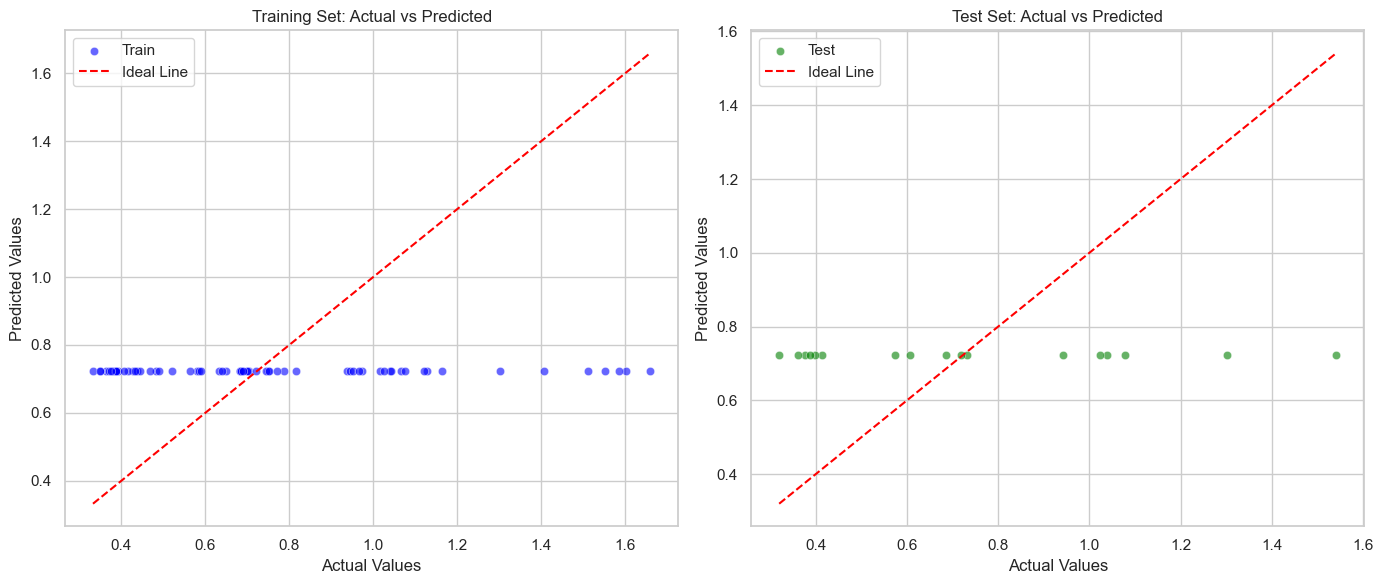

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Flatten y_pred if necessary
y_pred_flat = y_pred.flatten()

# Create DataFrames for Seaborn
train_df = pd.DataFrame({
    'Actual': y_train,
    'Predicted': lstm_model.predict(X_train).flatten(),
    'Data Type': 'Train'
})

test_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_flat,
    'Data Type': 'Test'
})

# Concatenate training and test data
df_combined = pd.concat([train_df, test_df], ignore_index=True)

# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Training set plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train_df, x='Actual', y='Predicted', color='blue', alpha=0.6, label='Train')
sns.lineplot(data=train_df, x='Actual', y='Actual', color='red', linestyle='--', label='Ideal Line')
plt.title('Training Set: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Test set plot
plt.subplot(1, 2, 2)
sns.scatterplot(data=test_df, x='Actual', y='Predicted', color='green', alpha=0.6, label='Test')
sns.lineplot(data=test_df, x='Actual', y='Actual', color='red', linestyle='--', label='Ideal Line')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.tight_layout()
plt.show()


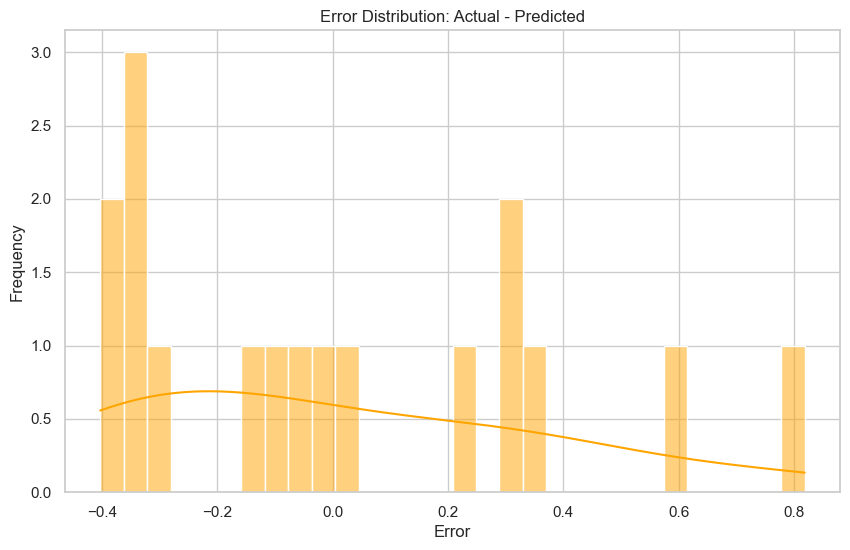

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate errors
test_df['Errors'] = test_df['Actual'] - test_df['Predicted']

# Plot error distribution
plt.figure(figsize=(10, 6))
sns.histplot(test_df['Errors'], bins=30, kde=True, color='orange')
plt.title('Error Distribution: Actual - Predicted')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()
